In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

Available backends: simple, igraph


In [13]:
circ = zx.examples.cliffords(5, 20)

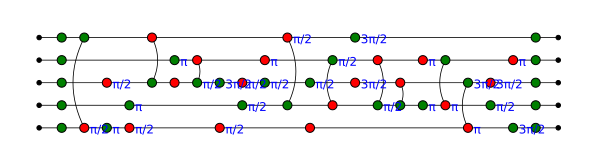

In [14]:
zx.draw(circ)

In [9]:
#zx.spider_simp(circ)
#zx.simplify.to_gh(circ)

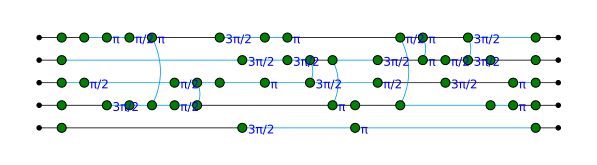

In [10]:
zx.draw(circ)

In [17]:
zx.clifford_simp(circ)
zx.drawing.pack_circuit_nf(circ,'gslc')
#zx.spider_simp(circ)

spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations


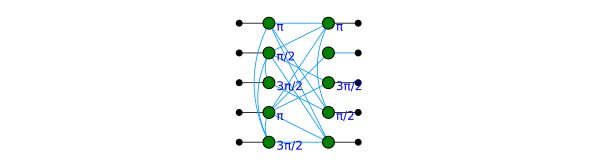

In [18]:
zx.draw(circ)

In [24]:
zx.drawing.pack_circuit_nf(circ,'gslc')

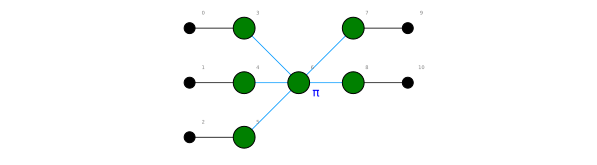

In [2]:
tree = zx.Graph()
ty = [0,0,0,   1,1,1,   1,    1,1,   0,0]
q  = [0,1,2,   0,1,2,   1,    0,1,   0,1]
r  = [0,0,0,   1,1,1,   2,    3,3,   4,4]
tree.add_vertices(len(ty))
for i,t in enumerate(ty):
    tree.set_type(i, t)
    tree.set_vdata(i, 'q', q[i])
    tree.set_vdata(i, 'r', r[i])
tree.add_edges([(0,3), (1,4), (2,5)])
tree.add_edges([(3,6), (4,6), (5,6), (6,7), (6,8)], edgetype=2)
tree.add_edges([(7,9), (8,10)])
tree.set_angle(6, 1)
zx.draw(tree, labels=True, h_edge_draw='blue')

In [3]:
m = zx.match_pivot_parallel(tree)
m

[[6, 7, [], [9], [8, 3, 4, 5], [], []]]

In [4]:
zx.pivot(tree, m)

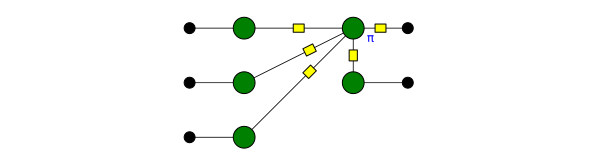

In [5]:
zx.draw(tree)

In [3]:
tree = zx.Graph()
ty = [0,0,0,   1,1,1,   1,   1,   1,1,   0,0]
q  = [0,1,2,   0,1,2,   1,   1,   0,1,   0,1]
r  = [0,0,0,   1,1,1,   2,   3,   4,4,   5,5]
tree.add_vertices(len(ty))
for i,t in enumerate(ty):
    tree.set_type(i, t)
    tree.set_vdata(i, 'q', q[i])
    tree.set_vdata(i, 'r', r[i])
tree.add_edges([(0,3), (1,4), (2,5)])
tree.add_edges([(3,6), (4,6), (5,6), (6,7), (7,8), (7,9), (3,8), (5,7)], edgetype=2)
tree.add_edges([(8,10), (9,11)])
tree.set_angle(6, 1)

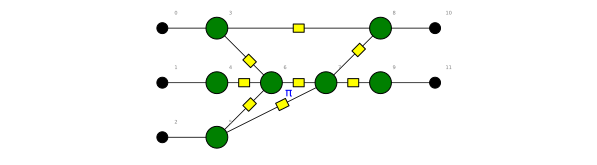

In [4]:
zx.draw(tree, labels=True)

In [5]:
tree1 = tree.copy()
zx.match_pivot_parallel(tree1)
#zx.lcomp(tree1, zx.rules.match_lcomp_parallel(tree1))
#zx.draw(tree1, labels=True)

[[6, 7, [], [], [3, 4], [8, 9], [5]]]

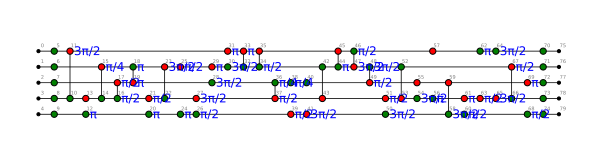

In [25]:
random.seed(34249)
cliff = zx.examples.cliffords(5,30)
cliff.set_angle(15, 1/4)
cliff.set_angle(36, 1/4)
cliff.set_angle(38, 1/4)
zx.draw(cliff, labels=True)

In [26]:
zx.clifford_simp(cliff)

spider_simp
14. 10. 5. 5. 2. 2. 1. 
finished in 8 iterations
pivot_simp
4. 
finished in 2 iterations
lcomp_simp
7. 3. 1. 1. 
finished in 5 iterations
pivot_simp
1. 1. 1. 
finished in 4 iterations


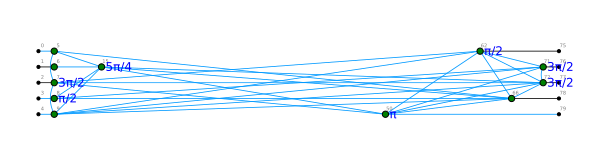

In [27]:
#zx.drawing.pack_circuit_nf(cliff, 'gslc')
zx.draw(cliff, h_edge_draw='blue', labels=True)

In [18]:
[cliff.get_type(n) for n in cliff.get_neighbours(103)]

[1, 1, 1, 1, 1, 1, 1]

In [31]:
random.seed(133)
%time g = zx.examples.cliffords(5,10**4)
%time zx.simplify.clifford_simp(g)

Wall time: 683 ms
spider_simp
4016. 2678. 1632. 956. 484. 178. 42. 15. 4. 
finished in 10 iterations
pivot_simp
1327. 488. 172. 53. 4. 2. 
finished in 7 iterations
lcomp_simp
2358. 869. 581. 377. 310. 234. 188. 148. 130. 107. 86. 63. 59. 47. 42. 39. 36. 34. 24. 25. 23. 15. 18. 10. 12. 8. 6. 8. 10. 4. 4. 8. 4. 4. 3. 2. 2. 2. 1. 2. 3. 
finished in 42 iterations
pivot_simp
1. 
finished in 2 iterations
Wall time: 5.69 s


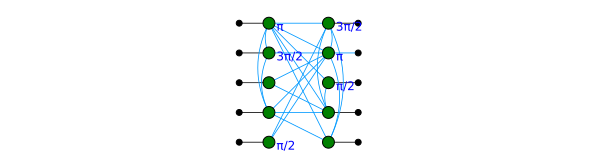

In [32]:
zx.drawing.pack_circuit_nf(g, 'gslc')
zx.draw(g, h_edge_draw='blue')

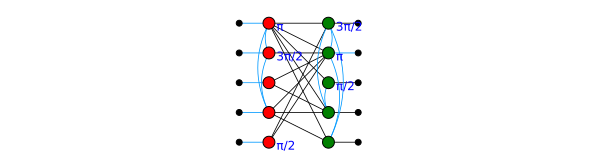

In [33]:
zx.to_rg(g, select=lambda v: g.get_vdata(v,'r') == 1)
zx.draw(g, h_edge_draw='blue')